In this notebook, we will be building our model for the open-world experiments to binary classify by determining whether the web traffic trace corresponds to a monitored website or unmonitored website.   

# Extracting Data

To begin, we will first import the dataframes into this notebook

In [1]:
import pickle

In [2]:
with open('datasets/extracted_features.pkl', 'rb') as f:
    df = pickle.load(f)

For this experiment, we consider the monitored websites as positive samples and the unmonitored websites as negative samples, so we will assign the label 1 to all monitored websites and 0 to the unmonitored ones.

In [3]:
df.loc[df['label'] >= 0, 'label'] = 1
df.loc[df['label'] <0, 'label'] = 0
df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,1,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,1,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,1,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,1,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,1,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,0,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,0,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,0,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,0,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


Then we will split the different features and labels of the data into training and testing sets

In [4]:
import sklearn
from sklearn.model_selection import train_test_split

# Separating Labels and Features
X = df.drop(columns=['label'])
y = df['label']

# Splitting into testing and training data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)

# Feature Importance
We can build a first Random Forest model to study the feature importance using the sklearn library.

In [5]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Creating a model
model_1= RandomForestClassifier()
model_1.fit(X_train, y_train)

# Computing a feature ranking
feature_imp = pd.Series(model_1.feature_importances_, index=X.columns).sort_values(ascending=False)

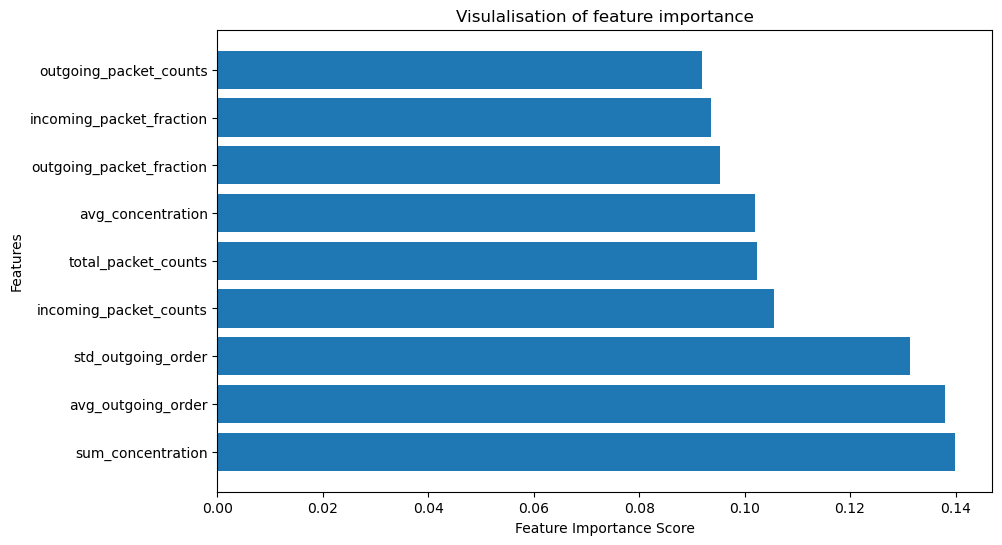

In [6]:
plt.figure(figsize=(10, 6))
plt.barh(feature_imp.index, feature_imp.values)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visulalisation of feature importance')
plt.show()

We can see that there are three 'top features' that seem to be relatively more significant than the other ones. Two of these however are from the same group (avg outoing order and std outgoing order)

# Model Creation
We can test this first model made from five features to see how it performs. The default configuration is to use gini impurity decrease to build 100 classifiers, with each having a maximum of features equal to the square root number of the total features which here is 2.  
As we are studying a binary classification, it is interesting to study the confusion matrix. We can think of a use case where monitored websites represent a specific kind of service for which we want to measure the frequence of access.

In [8]:
# Testing the First model using cross-validation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

results = cross_validate(
    model_1,
    X,y,cv=5,scoring=['accuracy', 'recall_macro'],)

print(f"Accuracy scores for the different folds: {results['test_accuracy']}")
print(f"Mean accuracy: {results['test_accuracy'].mean():.2f}")

print(f"Recall scores for the different folds: {results['test_recall_macro']}")
print(f"Mean recall: {results['test_recall_macro'].mean():.2f}")

# Displaying the confusion matrix for the split of the first model
y_pred_1 = model_1.predict(X_test)

print(confusion_matrix(y_test, y_pred_1))

Accuracy scores for the different folds: [0.50913793 0.56517241 0.51155172 0.59310345 0.58413793]
Mean accuracy: 0.55
Recall scores for the different folds: [0.54356579 0.57638158 0.54434211 0.59686842 0.59286842]
Mean recall: 0.57
[[1204  796]
 [ 419 3381]]


These first results are not so good.

# Model Tuning
We can use a grid search to see if the model reaches a better performance. Since this model uses binary classfication on a relatively small number of features, we will only look for the best number of estimators and the best criterion for feature importance.

In [10]:
from sklearn.model_selection import GridSearchCV

# Searching for the best building configuration
parameters = {'n_estimators': [20, 50, 100, 200], 'criterion' :['gini', 'entropy']}
model_2 = GridSearchCV(RandomForestClassifier(), parameters, refit = True)
model_2.fit(X_train, y_train)

print("Best parameters :",model_2.best_params_)

c:\Users\maray\miniconda3\envs\mlpro\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters : {'criterion': 'gini', 'n_estimators': 200}


Now we can test the model that uses the theoretical best parameters

In [11]:

results_2 = cross_validate(
    model_2,
    X,y,cv=5,scoring=['accuracy', 'recall_macro'],)

print(f"Accuracy scores for the different folds: {results_2['test_accuracy']}")
print(f"Mean accuracy: {results_2['test_accuracy'].mean():.2f}")

print(f"Recall scores for the different folds: {results_2['test_recall_macro']}")
print(f"Mean recall: {results_2['test_recall_macro'].mean():.2f}")

# Displaying the confusion matrix for the split of the first model
y_pred_2 = model_2.predict(X_test)

print(confusion_matrix(y_test, y_pred_2))

Accuracy scores for the different folds: [0.51086207 0.56482759 0.51224138 0.60258621 0.58293103]
Mean accuracy: 0.55
Recall scores for the different folds: [0.54263158 0.57517105 0.54368421 0.60528947 0.58815789]
Mean recall: 0.57
[[1196  804]
 [ 418 3382]]



model1  
Accuracy scores for the different folds: [0.50913793 0.56517241 0.51155172 0.59310345 0.58413793]  
Mean accuracy: 0.55  
Recall scores for the different folds: [0.54356579 0.57638158 0.54434211 0.59686842 0.59286842]  
Mean recall: 0.57  
[[1204  796]  
 [ 419 3381]]  

model2    
Accuracy scores for the different folds: [0.51086207 0.56482759 0.51224138 0.60258621 0.58293103]  
Mean accuracy: 0.55  
Recall scores for the different folds: [0.54263158 0.57517105 0.54368421 0.60528947 0.58815789]  
Mean recall: 0.57  
[[1196  804]  
 [ 418 3382]]  